事先資料準備：
1. 下載Kaggle的Real/Fake News Dataset news.csv，放在Google Drive /transformers/data 裡：https ://www.kaggle.com/nopdev/real-and-fake-news-dataset
2. 在Colab 執行 Preprocessing of Fake News Dataset.ipynb
3. 要將Goggle Drive Mount 到 Colab的 Container，中間需要Authorization Code


# Parameters

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
source_folder = '/content/drive/My Drive/transformers/data'
destination_folder = '/content/drive/My Drive/transformers/model'

# Libraries

加載Transformer

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.3MB 9.6MB/s 
     |████████████████████████████████| 890kB 52.8MB/s 
     |████████████████████████████████| 2.9MB 53.1MB/s 
     |████████████████████████████████| 1.1MB 55.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=f4155bcbd6f31b032dafea22b9972f8b1888de26ee525c6e5f464b273fdc98a5
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
# 載入程式庫

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries
# 載入 PyTorch 程式庫

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# 載入 建 Fine-Tune Classification 模型 程式庫

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# 載入訓練(優化器) 程式庫

import torch.optim as optim

# 載入驗證程式庫

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Preliminaries

In [ ]:
#BERT(BASE-UNCASED) Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# 模型參數
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# 標籤欄位與文句欄位

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
# fields 共有4欄位：label, title, text,titletext
fields = [('label', label_field), ('title', text_field), ('text', text_field), ('titletext', text_field)]

# 從 TabularDataset 填入train, valud, test dataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',
                                           test='test.csv', format='CSV', fields=fields, skip_header=True)

# 提供串流 Iterators

train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

Token indices sequence length is longer than the specified maximum sequence length for this model (706 > 512). Running this sequence through the model will result in indexing errors


# Models

In [ ]:
#BERT 模型 class 
#encoder 是從 pretrained bert-base-uncased 得來的 BertForSequenceClassification
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

# Training

In [ ]:
# Save and Load Functions
# checkpoint:當時model狀況
# metrics: loss/accuracy
def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [ ]:
# Training Function
# 訓練函數
def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # 訓練迴圈 training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, title, text, titletext), _ in train_loader:
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            titletext = titletext.type(torch.LongTensor)  
            titletext = titletext.to(device)
            output = model(titletext, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 更新損失值 update running values
            running_loss += loss.item()
            global_step += 1

            # eval_every 圈驗證1次 evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # 驗證迴圈 validation loop
                    for (labels, title, text, titletext), _ in valid_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        titletext = titletext.type(torch.LongTensor)  
                        titletext = titletext.to(device)
                        output = model(titletext, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # 驗證train/vlidate 損失值 evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # 重置損失值 resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # 印出進展 print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # 存入模型和損失狀態 checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [ ]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
#訓練開始
train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch [1/5], Step [16/160], Train Loss: 0.6971, Valid Loss: 0.6856
Model saved to ==> /content/drive/My Drive/transformers/model/model.pt
Model saved to ==> /content/drive/My Drive/transformers/model/metrics.pt
Epoch [1/5], Step [32/160], Train Loss: 0.5367, Valid Loss: 0.5102
Model saved to ==> /content/drive/My Drive/transformers/model/model.pt
Model saved to ==> /content/drive/My Drive/transformers/model/metrics.pt
Epoch [2/5], Step [48/160], Train Loss: 0.4035, Valid Loss: 0.3566
Model saved to ==> /content/drive/My Drive/transformers/model/model.pt
Model saved to ==> /content/drive/My Drive/transformers/model/metrics.pt
Epoch [2/5], Step [64/160], Train Loss: 0.2158, Valid Loss: 0.3101
Model saved to ==> /content/drive/My Drive/transformers/model/model.pt
Model saved to ==> /content/drive/My Drive/transformers/model/metrics.pt
Epoch [3/5], Step [80/160], Train Loss: 0.1775, Valid Loss: 0.3050
Model saved to ==> /content/drive/My Drive/transformers/model/model.pt
Model saved to ==>

Model loaded from <== /content/drive/My Drive/transformers/model/metrics.pt


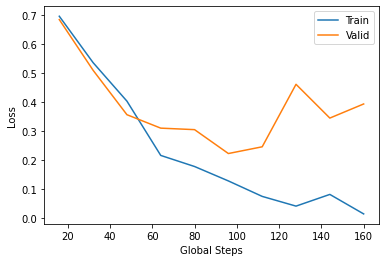

In [ ]:
#繪出損失圖
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

# Evaluation

In [ ]:
# Evaluation Function
# 定義驗證涵數
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, title, text, titletext), _ in test_loader:

                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                titletext = titletext.type(torch.LongTensor)  
                titletext = titletext.to(device)
                output = model(titletext, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content/drive/My Drive/transformers/model/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.9496    0.9023    0.9253      2816
           0     0.9081    0.9527    0.9299      2854

    accuracy                         0.9277      5670
   macro avg     0.9289    0.9275    0.9276      5670
weighted avg     0.9287    0.9277    0.9276      5670



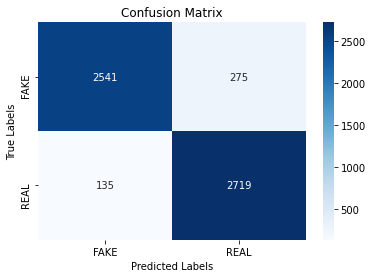

In [ ]:
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)